# Hierarchical Forecasting: Single-level Approaches

In this notebook, we go through the more traditional single-level approach to forecasting hierarchical or grouped time series. The concept is simple: either an aggregation or a disaggregation step is conducted on a single level (base forecast) to obtain coherent forecasts for the rest of the structure.

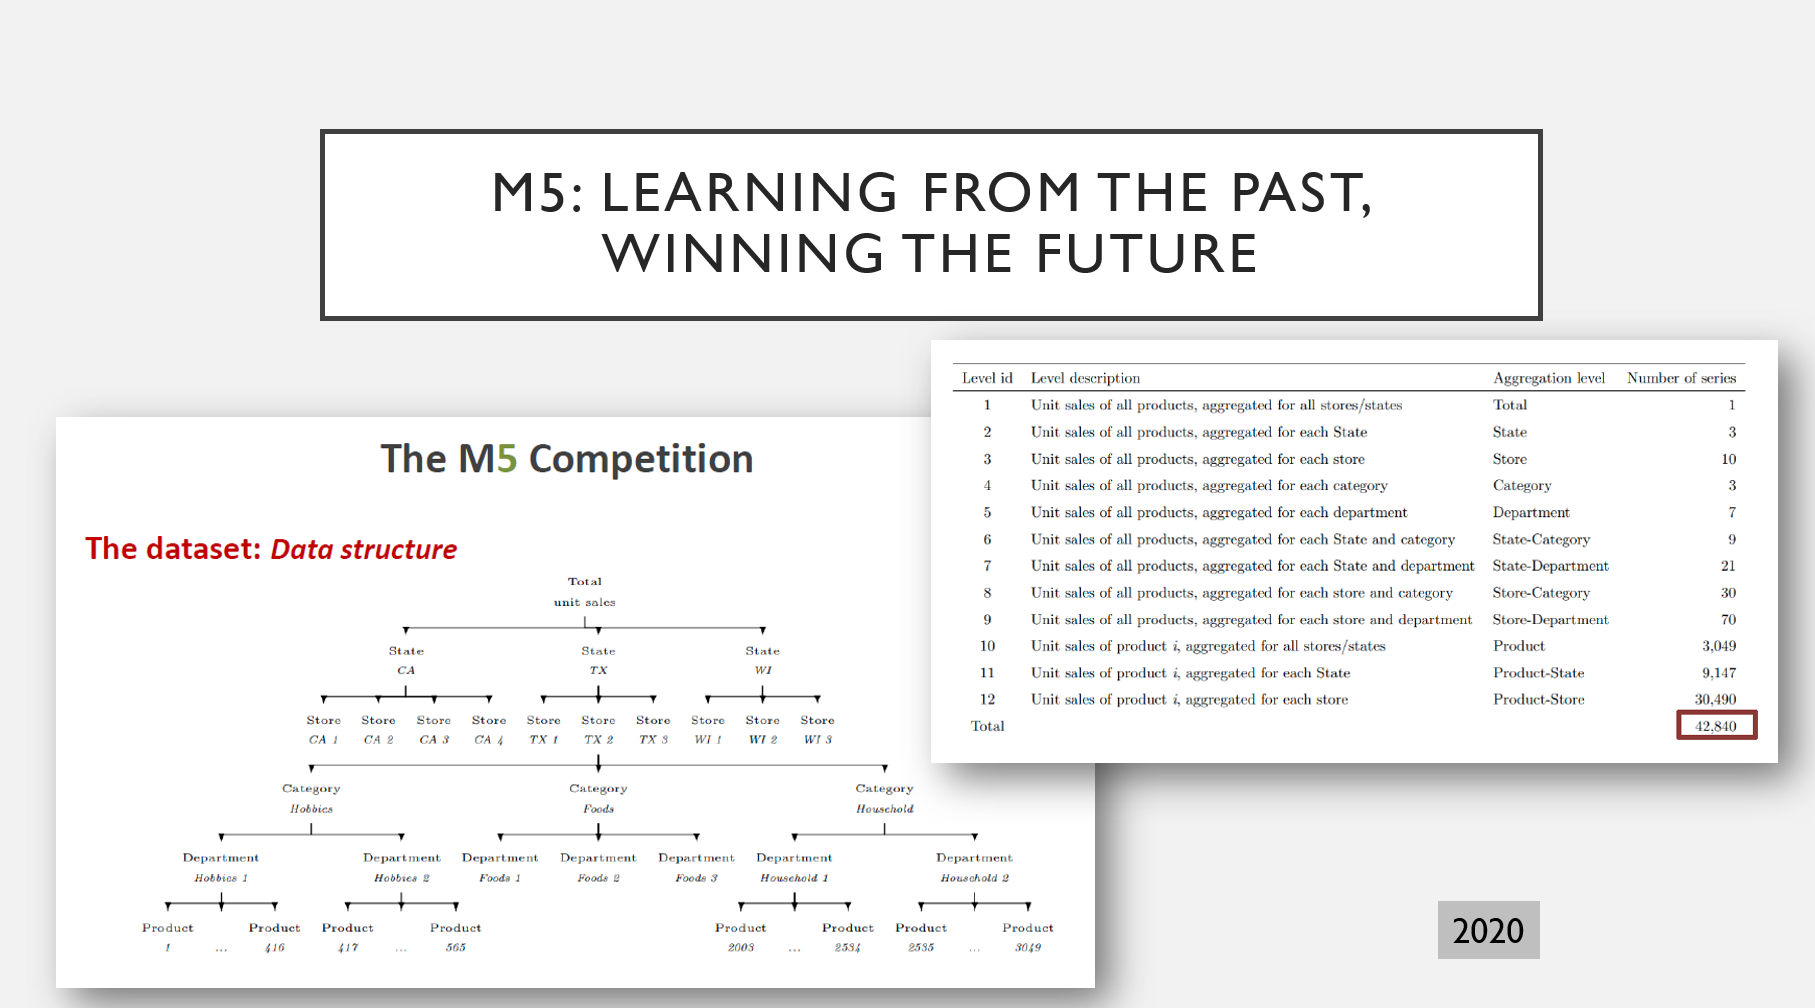

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [13]:
train = pd.read_csv('dataset/sales_train_evaluation.csv')
train.head(5)

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


Suppose we are forecasting at `level_id` 9. We shall construct a function that performs top-down and bottom-up approaches to obtain forecasts at other levels.

In [46]:
level_indexes = {
    'level1' : None,
    'level2': 'state_id', 
    'level3': 'store_id', 
    'level4': 'cat_id', 
    'level5': 'dept_id',
    'level6': ['state_id', 'cat_id'], 
    'level7' : ['state_id', 'dept_id'],
    'level8' : ['store_id', 'cat_id'],
    'level9' : ['store_id', 'dept_id'],
    'level10': ['item_id'],
    'level11': ['item_id', 'state_id'],
    'level12': ['item_id', 'store_id']
}

In [47]:
level9_forecasts = train.groupby(level_indexes['level9']).sum().iloc[:, -28:]
level9_forecasts.head(5)

d_1914  d_1915  d_1916  d_1917  d_1918  d_1919  d_1920  \
store_id dept_id                                                             
CA_1     FOODS_1       294     259     268     328     387     455     403   
         FOODS_2       458     500     412     400     463     653     720   
         FOODS_3      2141    1759    1787    1718    2182    2842    3131   
         HOBBIES_1     546     395     418     385     550     574     625   
         HOBBIES_2      43      31      33      47      34      62      59   

                    d_1921  d_1922  d_1923  ...  d_1932  d_1933  d_1934  \
store_id dept_id                            ...                           
CA_1     FOODS_1       262     332     272  ...     412     435     415   
         FOODS_2       620     525     531  ...     545     611     781   
         FOODS_3      2396    2140    2037  ...    2408    3000    3521   
         HOBBIES_1     478     582     522  ...     546     732     631   
         HOBBIES_2      51      46      43  ...      42      74      56   

                    d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
store_id dept_id                                                            
CA_1     FOODS_1       277     302     397     330     310     427     334  
         FOODS_2       555     476     427     411     434     627     719  
         FOODS_3      2366    2016    1992    2113    2249    2729    3274  
         HOBBIES_1     389     347     353     354     494     656     588  
         HOBBIES_2      28      46      28      52      45      63      58  

[5 rows x 28 columns]

## Bottom Up

Bottom up approach is straightforward. Forecasts at finer levels are aggregated to get the forecasts at other levels. In this case we forecast `level_id`s 1 to 8 using a bottom up approach from `level_id` 9. We can observe that `level_id`s 1 to 8 are aggregations that can be obtained from the `store_id` and `dept_id`.

**Advantage**
* No loss of information due to aggregation

**Disadvantage**
* Forecasting bottom-level data can be challenging given that these are usually quite noisy.

In [48]:
# reconstructing ids at higher level aggregations
state_id = [i[0].split('_')[0] for i in level9_forecasts.index]
cat_id = [i[1].split('_')[0] for i in level9_forecasts.index]

level9_forecasts = level9_forecasts.reset_index()
level9_forecasts['state_id'] = state_id
level9_forecasts['cat_id'] = cat_id
level9_forecasts.set_index(['state_id', 'store_id', 'cat_id', 'dept_id'], inplace=True)
level9_forecasts.head()

d_1914  d_1915  d_1916  d_1917  d_1918  \
state_id store_id cat_id  dept_id                                             
CA       CA_1     FOODS   FOODS_1       294     259     268     328     387   
                          FOODS_2       458     500     412     400     463   
                          FOODS_3      2141    1759    1787    1718    2182   
                  HOBBIES HOBBIES_1     546     395     418     385     550   
                          HOBBIES_2      43      31      33      47      34   

                                     d_1919  d_1920  d_1921  d_1922  d_1923  \
state_id store_id cat_id  dept_id                                             
CA       CA_1     FOODS   FOODS_1       455     403     262     332     272   
                          FOODS_2       653     720     620     525     531   
                          FOODS_3      2842    3131    2396    2140    2037   
                  HOBBIES HOBBIES_1     574     625     478     582     522   
                          HOBBIES_2      62      59      51      46      43   

                                     ...  d_1932  d_1933  d_1934  d_1935  \
state_id store_id cat_id  dept_id    ...                                   
CA       CA_1     FOODS   FOODS_1    ...     412     435     415     277   
                          FOODS_2    ...     545     611     781     555   
                          FOODS_3    ...    2408    3000    3521    2366   
                  HOBBIES HOBBIES_1  ...     546     732     631     389   
                          HOBBIES_2  ...      42      74      56      28   

                                     d_1936  d_1937  d_1938  d_1939  d_1940  \
state_id store_id cat_id  dept_id                                             
CA       CA_1     FOODS   FOODS_1       302     397     330     310     427   
                          FOODS_2       476     427     411     434     627   
                          FOODS_3      2016    1992    2113    2249    2729   
                  HOBBIES HOBBIES_1     347     353     354     494     656   
                          HOBBIES_2      46      28      52      45      63   

                                     d_1941  
state_id store_id cat_id  dept_id            
CA       CA_1     FOODS   FOODS_1       334  
                          FOODS_2       719  
                          FOODS_3      3274  
                  HOBBIES HOBBIES_1     588  
                          HOBBIES_2      58  

[5 rows x 28 columns]

In [120]:
def generate_bu(level_id, forecast_df):
    """Return forecasted dataframe of level_id using bottom up approach 
    from a reference forecast dataframe of a bottom aggregation level
    """
    index = level_indexes[level_id]
    if index:
        level_forecasts = forecast_df.groupby(index).sum()
    else:
        level_forecasts = forecast_df.sum().to_frame().T
    return level_forecasts

# test : level 8 forecast
generate_bu('level8', level9_forecasts).head()

d_1914  d_1915  d_1916  d_1917  d_1918  d_1919  d_1920  \
store_id cat_id                                                              
CA_1     FOODS        2893    2518    2467    2446    3032    3950    4254   
         HOBBIES       589     426     451     432     584     636     684   
         HOUSEHOLD     990     759     797     740     957    1312    1459   
CA_2     FOODS        2654    2306    2224    2457    2861    4041    4017   
         HOBBIES       361     336     360     400     438     594     579   

                    d_1921  d_1922  d_1923  ...  d_1932  d_1933  d_1934  \
store_id cat_id                             ...                           
CA_1     FOODS        3278    2997    2840  ...    3365    4046    4717   
         HOBBIES       529     628     565  ...     588     806     687   
         HOUSEHOLD     987     969     829  ...     998    1393    1303   
CA_2     FOODS        2995    2624    3015  ...    3255    3972    4285   
         HOBBIES       360     377     350  ...     370     687     588   

                    d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
store_id cat_id                                                             
CA_1     FOODS        3198    2794    2816    2854    2993    3783    4327  
         HOBBIES       417     393     381     406     539     719     646  
         HOUSEHOLD     953     762     798     876     901    1262    1316  
CA_2     FOODS        2902    2649    2561    2725    3179    4502    4198  
         HOBBIES       326     385     334     357     434     762     660  

[5 rows x 28 columns]

We iterate the following procedure on aggregation levels higher than `level_id` 9, `level_id`s 1 to 8. 

## Top Down

Top down approach on the contrary is a disaggregation step which may be done using three common methods:
* Proportions of historical averages
* Average historical proporions
* Forecast proportions

In the step below we construct top-down functions which use the first two methods. Unlike the third, the first two are based on historical proportions. As such we choose the a period `T` for which we base the proportions of the finer levels on.


As a demonstration, we make use of the last `T=28` days prior to the time interval we supposed as foreasts (last 28 days of the entire data in `sales_train_evaluation.csv`). Additionally, we explore getting the historical proportions using `level_id` 10--product (`item_id`) aggregation level.

**Advantage**
* Forecasts a top levels can be simpler, especially for time series of counts, less intermittent series values*. Top-level values tend to have sufficiently large counts (rarely, do we get zero counts).
* Reliable forecasts on the top levels. Can also be reliable at lower levels for low count data.


**Disadvantage**
* All top-down approaches tend to be biased even if the base forecasts (in our example, `level_id` 9) is unbiased. (Hyndman et al., 2011).
* Loss of information due to aggregation.
* Does not take advantage of bottom-level characteristics (e.g., time dynamics, special events, differnet seasonal patterns, etc.)

\**Note: For time series of counts, we may get series values of zero--like in the case of the early stages of new products in the supermarket. In dealing with such, we may need to employ more elaborate models suitable for a sample space of non-negative integers. (e.g. Croston's method--which constructs two series, one which is now the periods between zero values and non-zero values.)*

In [167]:
# construct data used to get historical proportions : prop_reference
T = 28 # period
use_index = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
prop_reference = train.set_index(use_index).iloc[:, -T*2:-T]
prop_reference.to_csv('dataset/proportions_reference.csv')
prop_reference.head(3)

,,,,,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
item_id,dept_id,cat_id,store_id,state_id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,0,0,0,1,0,4,2,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,1,0,0,0,...,2,1,2,1,1,1,0,1,1,1


### Proportions of historical averages

\begin{equation}
p_{j}=\sum_{t=1}^{T} \frac{y_{j, t}}{T} / \sum_{t=1}^{T} \frac{y_{t}}{T}
\end{equation}
> for $j = 1, ..., m$. Each proportion $p_j$ reflects the average of the historical proportions of the bottom-level series $y_{j,t}$ relative to the average value of the total aggregate $y_t$. This is implemented below as `get_prop_averages`.


In [109]:
# proportion_averages
yts = prop_reference.groupby('item_id').sum().sum()
yjts = prop_reference.groupby('item_id').sum()
pjs = ((yjts.sum(axis=1)/T) / (yts/T).sum())

# check if weights/proportions sum to 1 : good enough
pjs.sum()

0.9999999999999999

In [107]:
def get_prop_averages(level_id, prop_reference, T):
    """Returns the proportions of historical averages across a period T"""
    index = level_indexes[level_id]
    if index:
        yjts = prop_reference.groupby(index).sum()
        yts = yjts.sum()
        pjs = ((yjts.sum(axis=1)/T) / (yts/T).sum())
        return pjs
    else:
        raise "Inputted the top-most level. Try again."
        return None

In [111]:
# test function
get_prop_averages('level10', prop_reference, T).sum()

0.9999999999999999

### Average historical proportions

\begin{equation}
p_{j}=\frac{1}{T} \sum_{t=1}^{T} \frac{y_{j, t}}{y_{t}}
\end{equation}

> for $j = 1, ..., m$. Each proportion $p_j$ reflects the average of the historical proportions of the bottom-level series $y_{j,t}$ over the period $t=1, ..., T$ relative to the total aggregate $y_t$. This is implemented below as `get_ave_proportions`.

In [131]:
# average_proportions
yjts = prop_reference.groupby('item_id').sum()
yts = yjts.sum()
pjs = yjts.apply(lambda row: (row / yts).sum()/T, axis=1)

# check if weights/proportions sum to 1 : good enough
pjs.sum()

1.0

In [118]:
def get_ave_proportions(level_id, prop_reference, T):
    """Returns the average historical proportions across a period T"""
    index = level_indexes[level_id]
    if index:
        yjts = prop_reference.groupby(index).sum()
        yts = yjts.sum()
        pjs = yjts.apply(lambda row: (row / yts).sum()/T, axis=1)
        return pjs
    else:
        raise "Inputted the top-most level. Try again."
        return None

In [119]:
# test function
get_ave_proportions('level10', prop_reference, T).sum()

1.0

### Forecast Proportions

This is currently not implemented althought literature (Hyndman & Athansopoulos, 2018) states that often, using forecast proportions works better than other top-down methods.

The method is detailed in Athanasopoulos, et al. (2009). *See references below.*

### TD implementation

In [162]:
def generate_td(level_id, forecast_df, method, **kwargs):
    """Return forecasted dataframe of level_id using top_down approach 
    from a reference/base forecast dataframe of a higher aggregation level
    """
    pjs = method(level_id, **kwargs)
    yts = forecast_df.sum()
    index = level_indexes[level_id]
    level_forecasts = yts.apply(lambda x: x*pjs).round().astype(int).T
    return level_forecasts

In [165]:
generate_td('level12', level9_forecasts, get_ave_proportions, 
            prop_reference=prop_reference, T=28)

d_1914  d_1915  d_1916  d_1917  d_1918  d_1919  \
item_id         store_id                                                   
FOODS_1_001     CA_1           1       1       1       1       1       1   
                CA_2           1       1       1       1       1       1   
                CA_3           1       1       1       1       1       1   
                CA_4           0       0       0       0       0       0   
                TX_1           0       0       0       0       0       0   
...                          ...     ...     ...     ...     ...     ...   
HOUSEHOLD_2_516 TX_2           0       0       0       0       0       0   
                TX_3           0       0       0       0       0       0   
                WI_1           0       0       0       0       0       0   
                WI_2           0       0       0       0       0       0   
                WI_3           0       0       0       0       0       0   

                          d_1920  d_1921  d_1922  d_1923  ...  d_1932  d_1933  \
item_id         store_id                                  ...                   
FOODS_1_001     CA_1           2       1       1       1  ...       1       2   
                CA_2           1       1       1       1  ...       1       1   
                CA_3           1       1       1       1  ...       1       1   
                CA_4           0       0       0       0  ...       0       0   
                TX_1           0       0       0       0  ...       0       0   
...                          ...     ...     ...     ...  ...     ...     ...   
HOUSEHOLD_2_516 TX_2           0       0       0       0  ...       0       0   
                TX_3           0       0       0       0  ...       0       0   
                WI_1           0       0       0       0  ...       0       0   
                WI_2           0       0       0       0  ...       0       0   
                WI_3           0       0       0       0  ...       0       0   

                          d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  \
item_id         store_id                                                   
FOODS_1_001     CA_1           2       1       1       1       1       1   
                CA_2           2       1       1       1       1       1   
                CA_3           1       1       1       1       1       1   
                CA_4           0       0       0       0       0       0   
                TX_1           0       0       0       0       0       0   
...                          ...     ...     ...     ...     ...     ...   
HOUSEHOLD_2_516 TX_2           0       0       0       0       0       0   
                TX_3           0       0       0       0       0       0   
                WI_1           0       0       0       0       0       0   
                WI_2           0       0       0       0       0       0   
                WI_3           0       0       0       0       0       0   

                          d_1940  d_1941  
item_id         store_id                  
FOODS_1_001     CA_1           1       2  
                CA_2           1       1  
                CA_3           1       1  
                CA_4           0       0  
                TX_1           0       0  
...                          ...     ...  
HOUSEHOLD_2_516 TX_2           0       0  
                TX_3           0       0  
                WI_1           0       0  
                WI_2           0       0  
                WI_3           0       0  

[30490 rows x 28 columns]

## Middle-out Approach

Middle-out simply employs both top-down and bottom-up approaches when base forecasts are done on the middle aggregation levels of a hierarchical data. This is already illustrated through out the notebook, given that `level_id` 9 is a mid-level base forecast.

## References

Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice. OTexts.

Hyndman, R. J., Ahmed, R. A., Athanasopoulos, G., & Shang, H. L. (2011). Optimal combination forecasts for hierarchical time series. Computational Statistics and Data Analysis, 55(9), 2579–2589.

Athanasopoulos, G., Ahmed, R. A., & Hyndman, R. J. (2009). Hierarchical forecasts for Australian domestic tourism. International Journal of Forecasting, 25, 146–166.